# Dirichlet Process Mixture Models: count data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [14, 6]}
sns.set(rc = rc)
sns.set_style("whitegrid")

## Step 1: Prepare the data

Let's use an R dataset called "sunspot.year". It contains yearly numbers of sunspots, as from the World Data Center

In [2]:
import statsmodels as sm
df = sm.datasets.get_rdataset('sunspot.year', cache = True).data

In [9]:
df.tail()

,time,sunspot.year
284,1984,45.9
285,1985,17.9
286,1986,13.4
287,1987,29.2
288,1988,100.2


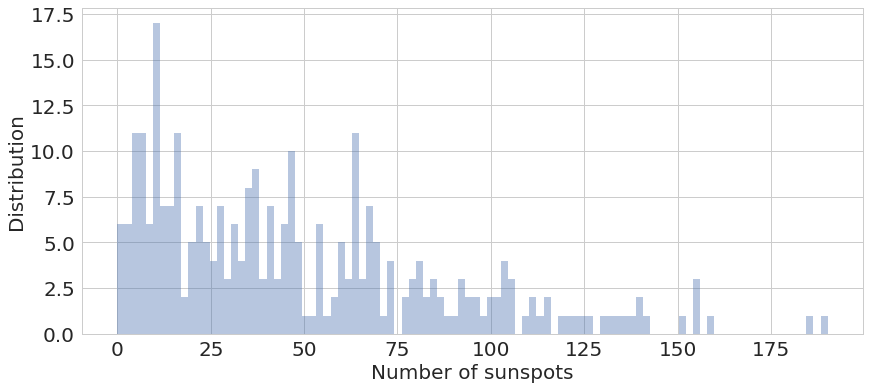

In [10]:
import plotly as py
fig, ax = plt.subplots()
ax = sns.distplot(bins = 100, kde = False, a = df["sunspot.year"])
ax.set_xlabel('Number of sunspots')
ax.set_ylabel('Distribution');
#py.offline.iplot_mpl(fig)
#plt.savefig('figpath1.svg', dpi = 400, bbox_inches = "tight")

Truncate the DP components that are stored after a fixed number of components, $K$.  
Ohlssen et al. (2007) proposed that $K > 5\alpha + 2$ is sufficient to capure almost all the of the mixture weights ($\sum_{k = 1}^{K} \pi_{k} > 0.999$)  
* We shall verify the suitability of the above truncation by checking the # of components that contribute non-negligible mass to the mixture  
** If, in our simulations, all components contribute non-negligible mass to the mixture, we have truncated the DP TOO EARLY**

In [12]:
N = df.shape[0] # the number of data points
# the number of clusters for N data points is < K
# K is the number of truncated components. recall that # components > # clusters
K = 50 # let's start with 13 components and we will perform a check for its suitability

In [13]:
N

289

## Step 2: Build the model

The $GEM$ is a type of stick breaking using beta distributions with $a = 1, b = \alpha$, i.e $V_k \sim Beta(1, \alpha)$

\begin{split}\begin{align*}
    \alpha
        & \sim \textrm{Gamma}(1, 1) \\
    v_1, \ldots, v_K
        & \sim \textrm{Beta}(1, \alpha) \\
    \pi_i
        & = v_i \prod_{j = i - 1}^i (1 - v_j) \\
    \\
    \lambda_1, \ldots, \lambda_K
        & \sim U(0, 300) \\
    y\ |\ \pi_i, \lambda_i
        & \sim \sum_{i = 1}^K \pi_i\ \textrm{Poisson}(\lambda_i).
\end{align*}\end{split}

In [24]:
def stick_breaking(v):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - v)[:-1]])

    return v * portion_remaining

In [25]:
with pm.Model() as dpmm_poisson:
    
    # specify the priors
    alpha = pm.Gamma('alpha', 1.0, 1.0)
    v = pm.Beta('v', 1, alpha, shape = K)
    pi = pm.Deterministic('pi', stick_breaking(v)) # stick-breaking proportions

    lambda_ = pm.Uniform('lambda_', 0.0, 300.0, shape = K)
    poisson_dist = pm.Poisson.dist(mu = lambda_) # poisson distribution
    
    # specify the data likelihood
    obs = pm.Mixture('obs', w = pi, comp_dists = poisson_dist, observed = df['sunspot.year'])

## Step 3: Sample from the posterior

In [37]:
with dpmm_poisson:
    step = pm.NUTS(target_accept = 0.999, adapt_step_size = 0.001, max_treedepth = 15)
    posterior = pm.sample(draws = 1000, njobs = 2, tune = 500, step = step)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 94%|█████████▎| 936/1000 [04:35<00:18,  3.40it/s]/home/emaasit/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning:

Chain 1 contains 139 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.

100%|██████████| 1000/1000 [04:50<00:00,  3.45it/s]/home/emaasit/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning:

Chain 0 contains 128 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.




## Step 4: Diagnose convergence of MCMC chains

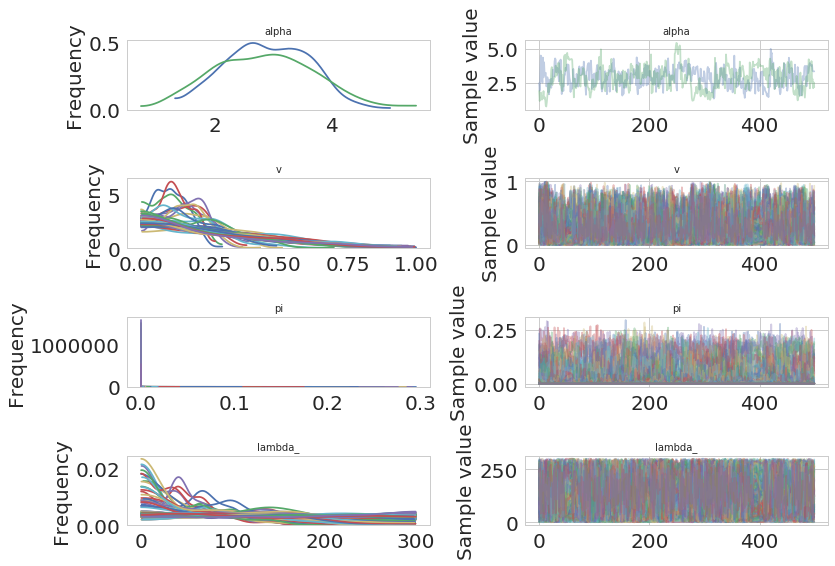

In [38]:
pm.traceplot(posterior);

In [39]:
pm.gelman_rubin(posterior)

{'alpha': 0.99966040495518604,
 'lambda_': array([ 1.11094866,  0.99923955,  1.00557704,  1.04114725,  1.04180788,
         1.00327633,  1.02646881,  1.00592418,  1.00366196,  1.01003518,
         1.00462035,  1.03433528,  1.01511174,  1.00073661,  1.00354954,
         0.99973038,  1.00005021,  0.9996706 ,  0.99904736,  1.00054469,
         1.00617471,  1.00164636,  0.9989995 ,  0.99904966,  1.00213352,
         0.99935439,  0.99905112,  0.99930938,  1.00556602,  1.00274656,
         1.0007974 ,  0.99918816,  1.002254  ,  0.9991785 ,  0.99905652,
         0.99964122,  0.99924426,  0.99900389,  0.99944328,  0.99903498,
         0.99967183,  1.00215637,  1.00199652,  0.9990398 ,  1.00033017,
         1.00210376,  0.99916664,  1.00116764,  1.00058669,  1.00557004]),
 'pi': array([ 1.00773893,  1.04095048,  1.01612902,  1.00778931,  1.00389116,
         1.00053217,  1.00941318,  1.03008797,  0.99944787,  1.00049898,
         1.01825795,  1.01255838,  1.00023171,  1.00779724,  1.0035927 ,
 

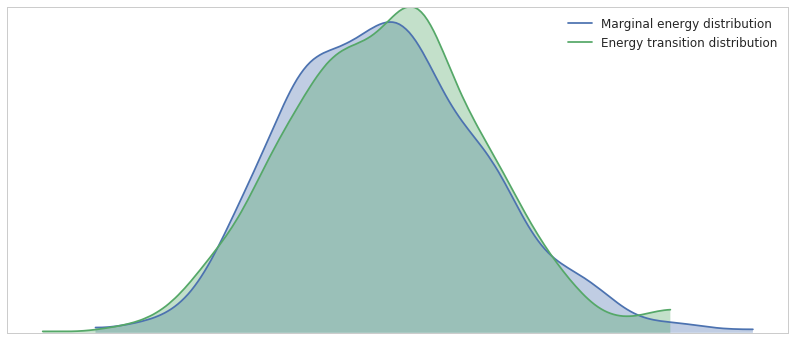

In [40]:
pm.energyplot(posterior);

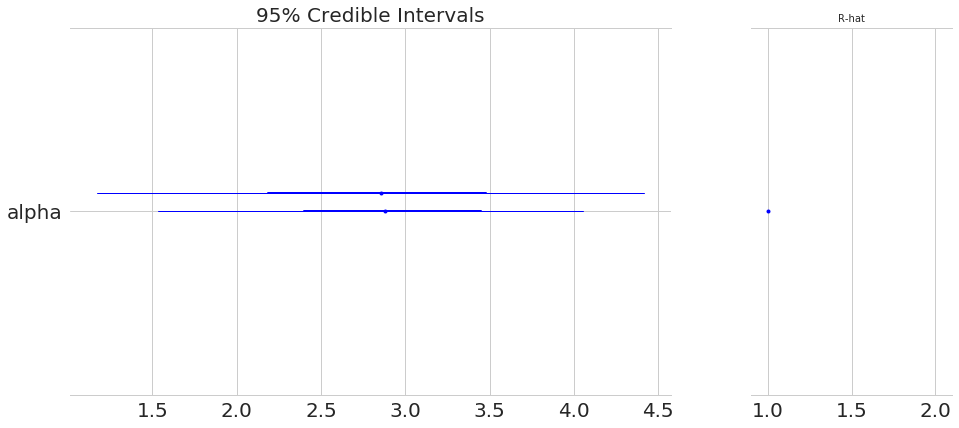

In [41]:
pm.forestplot(posterior, varnames = ["alpha"]);

## Step 5: Criticize the model

The posterior distribution of $\alpha$ is highly concentrated between 1.3 and 4.2.

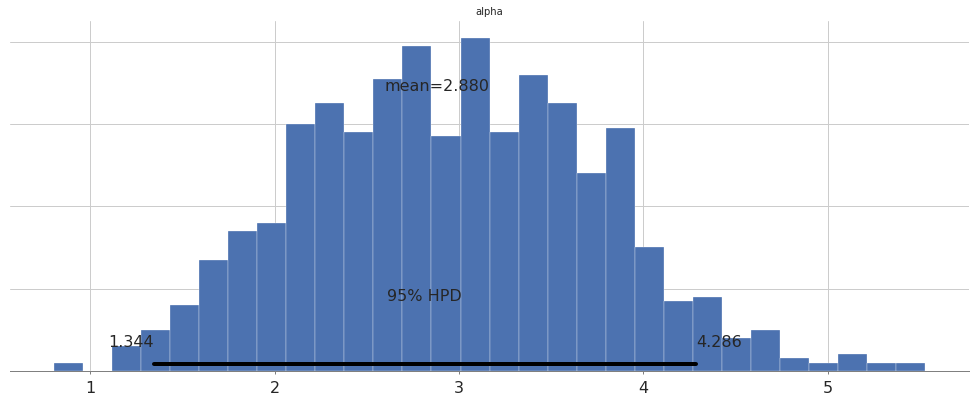

In [42]:
pm.plot_posterior(posterior, varnames = ["alpha"]);

### Check the suitability of our truncation
Plot the posterior expectation of proportions of each component.  

The figure below shows that atleast 29 components have posterior weight/proportion. This shows that truncation at K = 30 captures all the components in this data.

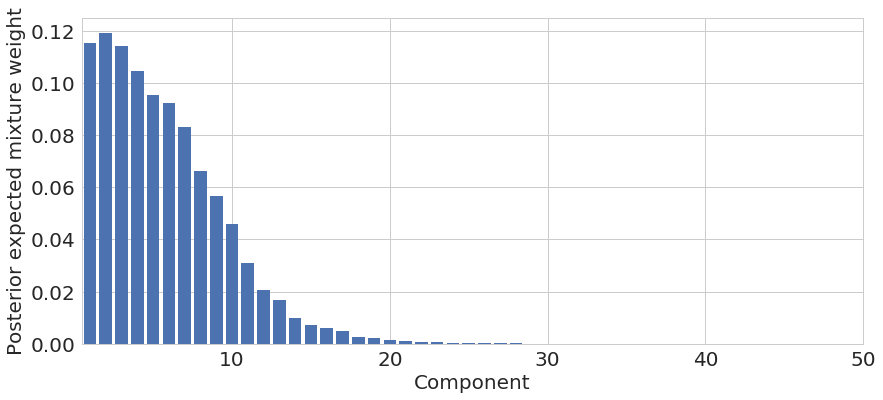

In [43]:
fig, ax = plt.subplots()

plot_pi = np.arange(K) + 1

ax.bar(plot_pi, posterior['pi'].mean(axis = 0)); # axis 0 is the columns

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

### Visualize the posterior density estimate

In [44]:
y_plot = np.arange(250)

In [45]:
import scipy as sp
post_pmf_contribs = sp.stats.poisson.pmf(np.atleast_3d(y_plot),
                                         posterior['lambda_'][:, np.newaxis, :])

post_pmfs = (posterior['pi'][:, np.newaxis, :] * post_pmf_contribs).sum(axis=-1)

post_pmf_low, post_pmf_high = np.percentile(post_pmfs, [2.5, 97.5], axis=0)

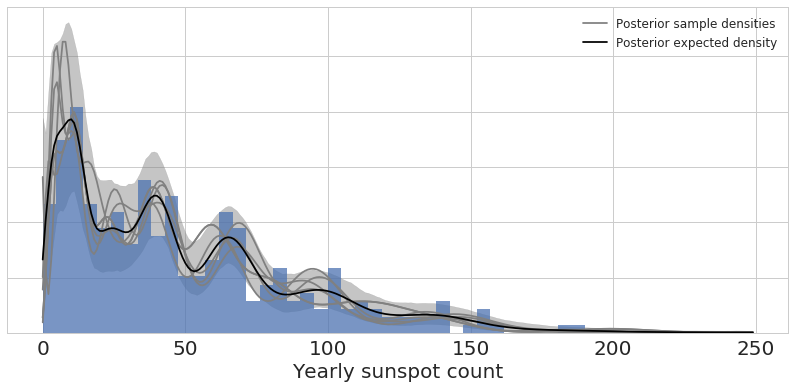

In [46]:
fig, ax = plt.subplots()

ax.hist(df['sunspot.year'].values, bins=40, normed=True, lw=0, alpha=0.75);

ax.fill_between(y_plot, post_pmf_low, post_pmf_high, color='gray', alpha=0.45)

ax.plot(y_plot, post_pmfs[0], c='gray', label='Posterior sample densities');

ax.plot(y_plot, post_pmfs[::200].T, c='gray');

ax.plot(y_plot, post_pmfs.mean(axis=0), c='k', label='Posterior expected density');

ax.set_xlabel('Yearly sunspot count');
ax.set_yticklabels([]);
ax.legend(loc=1);

Decompose the above density into its mixture components

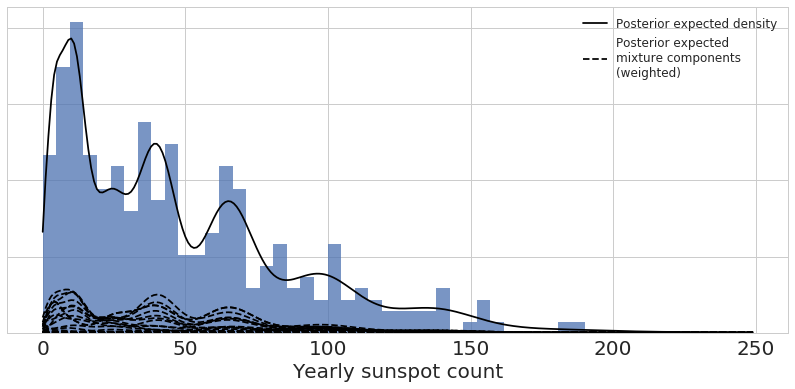

In [47]:
fig, ax = plt.subplots()

ax.hist(df['sunspot.year'].values, bins=40, normed=True, lw=0, alpha=0.75);

ax.plot(y_plot, post_pmfs.mean(axis=0), c='k', label='Posterior expected density');

ax.plot(y_plot, (posterior['pi'][:, np.newaxis, :] * post_pmf_contribs).mean(axis=0)[:, 0],
        '--', c='k', label='Posterior expected\nmixture components\n(weighted)');

ax.plot(y_plot, (posterior['pi'][:, np.newaxis, :] * post_pmf_contribs).mean(axis=0),
        '--', c='k');

ax.set_xlabel('Yearly sunspot count');
ax.set_yticklabels([]);
ax.legend(loc=1);